In [1]:
import os 
import sys

import pandas as pd
import numpy as np

import morfeus
import rdkit
import rdmetallics
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import confworks
from confworks.util import read_multiconf_sdf

In [2]:
path = '/home/galymzhan/Documents/louis_diels_alder_crest/crest_data/reactant_ch2cl2/'
xyz_filename = 'crest_conformers.xyz'
sdf_filename = 'crest_conformers.sdf'
template_sdf_filename = 'input.sdf'


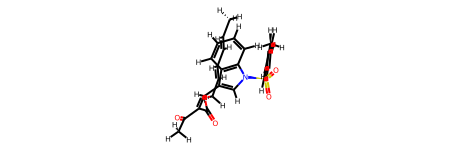

Found 544 conformers in /home/galymzhan/Documents/louis_diels_alder_crest/crest_data/reactant_ch2cl2/crest_conformers.xyz.
Successfully added 544 conformers to the template molecule.


In [4]:
import sys
from rdkit import Chem
from rdkit import Geometry as rdGeometry

def load_conformers_from_xyz(template_mol, xyz_file):
    template_mol = Chem.Mol(template_mol)
    """
    Loads coordinates from a multi-conformer XYZ file into a template RDKit molecule.

    CRITICAL ASSUMPTION:
    The atom order in the XYZ file is *exactly* the same as the atom order
    in the template_mol.
    """
    
    # --- 1. Read all coordinate blocks from the XYZ file ---
    all_coords = []
    conf_energy_list = []
    try:
        with open(xyz_file, 'r') as f:
            lines = f.readlines()
    except IOError:
        print(f"Error: Could not read XYZ file: {xyz_file}")
        return None

    i = 0
    while i < len(lines):
        try:
            # First line: Number of atoms
            num_atoms = int(lines[i].strip())
            
            # Second line: Energy
            i += 1
            conf_energy_list.append(float(lines[i].strip()))
            
            # Read the coordinates for this block
            i += 1

            coords = []
            for j in range(num_atoms):
                parts = lines[i+j].strip().split()
                # parts[0] is element, 1-3 are x, y, z
                x = float(parts[1])
                y = float(parts[2])
                z = float(parts[3])
                coords.append((x, y, z))
            
            all_coords.append(coords)
            
            # Move index to the start of the next block
            i += num_atoms
            
        except Exception as e:
            # Handle formatting errors or reaching end of file
            # print(f"Stopped parsing at line {i+1}: {e}")
            break
            
    if not all_coords:
        print(f"Error: No conformers found in {xyz_file}")
        return template_mol

    print(f"Found {len(all_coords)} conformers in {xyz_file}.")

    # --- 2. Add coordinates as new conformers to the template molecule ---
    num_atoms_template = template_mol.GetNumAtoms()
    
    # Clear any existing conformers from the template
    template_mol.RemoveAllConformers()
    
    confs_added = 0
    for i, coords_conf_E in enumerate(zip(all_coords, conf_energy_list)):
        coords, energy = coords_conf_E
        # ---!!!--- CRITICAL CHECK ---!!!---
        if len(coords) != num_atoms_template:
            print(f"Warning: Conformer {i} has {len(coords)} atoms, but template has {num_atoms_template}. Skipping.", file=sys.stderr)
            continue
            
        # Create a new conformer object
        conf = Chem.Conformer(num_atoms_template)
        
        # Set atom positions
        for atom_idx in range(num_atoms_template):
            x, y, z = coords[atom_idx]
            pos = rdGeometry.Point3D(x, y, z)
            conf.SetAtomPosition(atom_idx, pos)
            
        # Add the new conformer to the molecule
        # assignId=True will give it a unique ID
        conf_id = template_mol.AddConformer(conf, assignId=True)
        template_mol.GetConformer(conf_id).SetDoubleProp('conf_energy', energy)

        confs_added += 1
        
    print(f"Successfully added {confs_added} conformers to the template molecule.")
    return template_mol


filepath = os.path.join(path, template_sdf_filename)
mol = read_multiconf_sdf(filepath)
display(mol)

# if mol is None:
#     print(f"Could not load template molecule from {template_file}")
#     sys.exit(1)

# print(f"Loaded template molecule with {mol.GetNumAtoms()} atoms.")
# print(f"Template starts with {mol.GetNumConformers()} conformer(s).")

# # --- 4. Run the function ---
xyz_file = os.path.join(path, xyz_filename)
mol_with_conformers = load_conformers_from_xyz(mol, xyz_file)

# # --- 5. Save the result ---
# if mol_with_conformers and mol_with_conformers.GetNumConformers() > 0:
#     with Chem.SDWriter(output_file) as writer:
#         writer.write(mol_with_conformers)
        
#     print(f"\nSuccessfully saved molecule with {mol_with_conformers.GetNumConformers()} conformers to {output_file}")
    
#     # You can verify by reading it back
#     suppl_out = Chem.SDMolSupplier(output_file)
#     final_mols = [m for m in suppl_out]
#     print(f"Verification: Output file contains {len(final_mols)} molecule(s).")
#     if final_mols:
#         print(f"The molecule in the output file has {final_mols[0].GetNumConformers()} conformers.")
# else:
#     print("\nNo conformers were added. Output file not written.")

In [8]:
energies = set()
for i, conf in enumerate(mol_with_conformers.GetConformers()):
    conf_E = conf.GetDoubleProp('conf_energy')
    # print(i)
    # print(conf_E)
    energies.add(conf_E)

print(len(energies))

544
